# 1


In [1]:
!pip install roboflow tensorflow tensorflow_datasets opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 14.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
from roboflow import Roboflow
import tensorflow as tf
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="71wsAI6cjgikjxhU6YI4")
project = rf.workspace("pinokio-i1jvv").project("defects-in-3d-printing-hddtt")
version = project.version(1)
dataset = version.download("voc")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Defects-in-3D-Printing-1 in voc:: 100%|██████████| 95/95 [00:00<00:00, 1578.52it/s]


In [4]:
DATASET_PATH = dataset.location  # Путь к скачанному датасету
IMAGES_PATH = os.path.join(DATASET_PATH, "train")
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "train", "annotations")

IMG_SIZE = 512  # Размер изображений для модели
NUM_CLASSES = 21  # Укажите количество классов в датасете


In [5]:
def load_image_and_mask(image_file):
    # Загрузка изображения
    image = cv2.imread(os.path.join(IMAGES_PATH, image_file))
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Нормализация

    # Загрузка маски из XML (Pascal VOC)
    annotation_file = os.path.join(ANNOTATIONS_PATH, image_file.replace(".jpg", ".xml"))
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

    for obj in root.findall("object"):
        class_id = 1  # Можно настроить классы
        bbox = obj.find("bndbox")
        x_min = int(bbox.find("xmin").text)
        y_min = int(bbox.find("ymin").text)
        x_max = int(bbox.find("xmax").text)
        y_max = int(bbox.find("ymax").text)

        # Преобразование координат в (512x512)
        x_min, x_max = int(x_min * IMG_SIZE / 640), int(x_max * IMG_SIZE / 640)
        y_min, y_max = int(y_min * IMG_SIZE / 640), int(y_max * IMG_SIZE / 640)

        mask[y_min:y_max, x_min:x_max] = class_id

    return image, mask

In [6]:
image_files = [f for f in os.listdir(IMAGES_PATH) if f.endswith(".jpg")]
dataset = tf.data.Dataset.from_generator(
    lambda: (load_image_and_mask(f) for f in image_files),
    output_signature=(
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE), dtype=tf.uint8)
    )
)

In [7]:
train_data = dataset.batch(16).shuffle(100)

In [15]:
!pip install tensorflow --upgrade
!pip install tf-slim
!pip install tensorflow-model-optimization


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.2 MB/s eta 0:00:00


In [17]:
model = tf.keras.applications.Xception(
    input_shape=(512, 512, 3),
    weights="imagenet",  # Используем ImageNet (или `None` для обучения с нуля)
    include_top=False  # Убираем полносвязные слои
)

# Добавляем сегментацию поверх Xception
x = tf.keras.layers.Conv2D(21, (1, 1), activation="softmax")(model.output)  # 21 класс (можно изменить)
model = tf.keras.Model(inputs=model.input, outputs=x)

# Компиляция модели
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [20]:
from google.colab import drive
drive.mount('/content/drive')

# Сохранение в Google лукфы
model.save("/content/drive/MyDrive/deeplabv3_model.keras")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unique values in mask: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20]


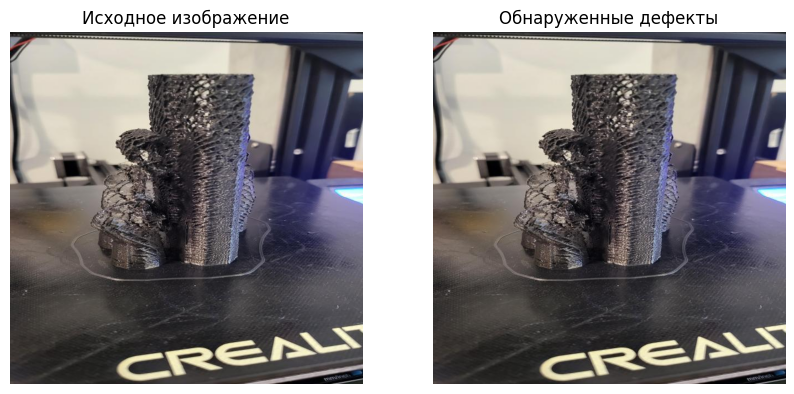

Unique values in mask: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20]


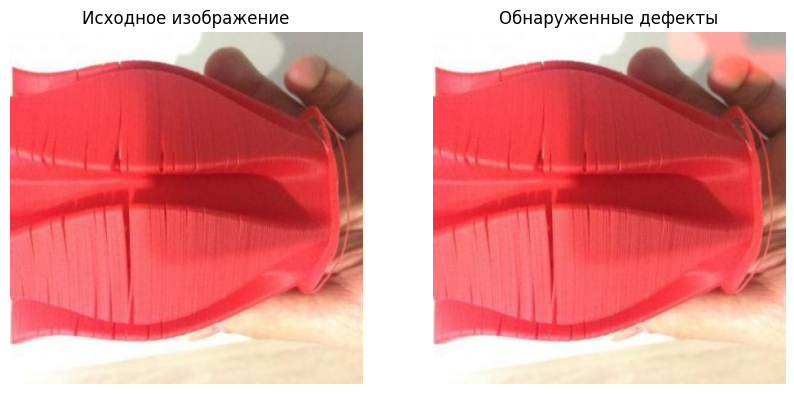

Unique values in mask: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20]


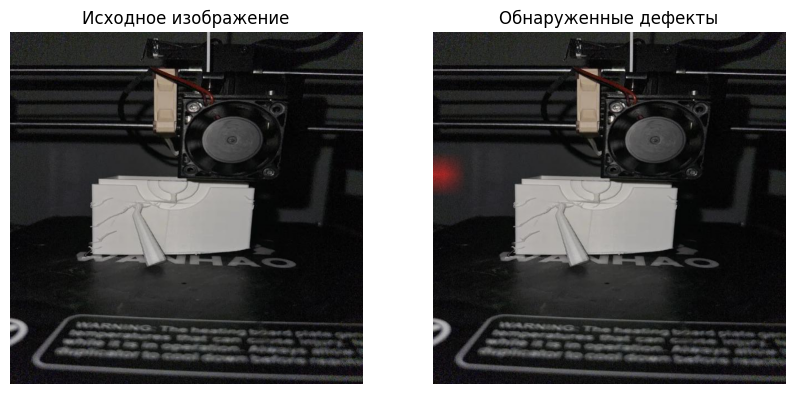

In [26]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# ✅ 1. Загрузка обученной модели
MODEL_PATH = "/content/drive/MyDrive/deeplabv3_model.keras"
model = tf.keras.models.load_model(MODEL_PATH)

# ✅ 2. Путь к тестовым изображениям
TEST_IMAGES_PATH = os.path.join(DATASET_PATH, "train")  # Или "test"

# ✅ 3. Функция предсказания дефектов с наложением на фото
def detect_defects_overlay(image_path, model, img_size=512, defect_class=1, alpha=0.5):
    """
    Определяет дефекты и накладывает их на оригинальное изображение.

    :param image_path: путь к изображению
    :param model: загруженная модель сегментации
    :param img_size: размер входного изображения для модели
    :param defect_class: ID класса, который соответствует дефектам
    :param alpha: прозрачность наложения дефектов (0 - прозрачный, 1 - плотный)
    :return: исходное изображение и изображение с наложенными дефектами
    """
    # 📌 Загружаем изображение
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_size = image.shape[:2]  # Запоминаем оригинальный размер
    resized_image = cv2.resize(image, (img_size, img_size)) / 255.0
    input_tensor = np.expand_dims(resized_image, axis=0)

    # 🔥 Предсказание маски
    prediction = model.predict(input_tensor, verbose=0)[0]
    mask = np.argmax(prediction, axis=-1)  # Выбираем класс с максимальной вероятностью
    defect_mask = (mask == defect_class).astype(np.uint8) * 255  # Оставляем только дефекты

    # 🟢 Возвращаем размер маски к оригиналу
    defect_mask = cv2.resize(defect_mask, (orig_size[1], orig_size[0]))

    # 🔴 Создаем красную маску для дефектов
    overlay = np.zeros_like(image)
    overlay[:, :, 0] = defect_mask  # Красный канал (RGB)

    # 🔄 Накладываем с прозрачностью
    highlighted = cv2.addWeighted(image, 1, overlay, alpha, 0)

    return image, highlighted

# ✅ 4. Тестируем несколько изображений
test_images = [f for f in os.listdir(TEST_IMAGES_PATH) if f.endswith(".jpg")]

for test_image in test_images[:3]:  # Покажем 3 примера
    image_path = os.path.join(TEST_IMAGES_PATH, test_image)
    original, defect_overlay = detect_defects_overlay(image_path, model)

    # ✅ 5. Визуализация результата
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Исходное изображение")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(defect_overlay)
    plt.title("Обнаруженные дефекты")
    plt.axis("off")
    print("Unique values in mask:", np.unique(mask))

    plt.show()
